##### Package imports

In [36]:
import xarray as xr
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from typing import Tuple

import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

##### Download Data
Go on the given URLs for model and reanalysis data:
model_url_Oct3rd_2019=https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(3%20Oct%202019)/VALUE/X/(-170)/(-30)/RANGE/Y/(20)/(80)/RANGE/hdate/(1999)/(2018)/RANGE/L/5/runningAverage/dup/%5Bhdate/M%5D/average/sub/S/removeGRID/data.nc
model_url_Dec5th_2019=https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(5%20Dec%202019)/VALUE/X/(-170)/(-30)/RANGE/Y/(20)/(80)/RANGE/hdate/(1999)/(2018)/RANGE/L/5/runningAverage/dup/%5Bhdate/M%5D/average/sub/S/removeGRID/data.nc
reanalysis_url_Oct3rd_2019=https://iridl.ldeo.columbia.edu/auth/login?ver=1&redirect=%2FSOURCES%2F.ECMWF%2F.S2S%2F.ECMF%2F.reforecast%2F.perturbed%2F.pressure_level_gh%2F.gh%2FP%2F500%2FVALUE%2FP%2FremoveGRID%2FS%2F%283%20Oct%202019%29%2FVALUE%2FX%2F%28-170%29%2F%28-30%29%2FRANGE%2FY%2F%2820%29%2F%2880%29%2FRANGE%2Fhdate%2F%281999%29%2F%282018%29%2FRANGE%2Fhdate%2F%2Fpointwidth%2F0%2Fdef%2F-6%2FshiftGRID%2Fhdate%2F%28days%20since%201960-01-01%29%2Fstreamgridunitconvert%2FS%2F%28days%20since%202018-01-01%29%2Fstreamgridunitconvert%2FS%2F%2Funits%2F%2Fdays%2Fdef%2FL%2F0.5%2Fadd%2Fhdate%2Fadd%2Fadd%2F%2Fpointwidth%2F1%2Fdef%2FSOURCES%2F.ECMWF%2F.ERA-Interim%2F.SIX-HOURLY%2F.pressure_level%2F.z500%2FT%2F3%2FshiftGRID%2FT%2F24%2FboxAverage%2FT%2F2%2Findex%2F.units%2Fstreamgridunitconvert%2Fexch%2F%5BT%5Dsample-along%2Fc%3A%2F9.81%2F%28m%20s-2%29%2F%3Ac%2Fdiv%2FS%2FremoveGRID%2FL%2F5%2FrunningAverage%2F%5BX%2FY%5D%2F1.0%2F0.%2FregridLinear%2Fdup%2F%5Bhdate%5Daverage%2F2%2FRECHUNK%2Fsub%2Fdata.nc&realm=iri.columbia.edu%2Fterms%2Fs2s%2F1
reanalysis_url_Dec5th_2019=https://iridl.ldeo.columbia.edu/auth/login?ver=1&redirect=%2FSOURCES%2F.ECMWF%2F.S2S%2F.ECMF%2F.reforecast%2F.perturbed%2F.pressure_level_gh%2F.gh%2FP%2F500%2FVALUE%2FP%2FremoveGRID%2FS%2F%285%20Dec%202019%29%2FVALUE%2FX%2F%28-170%29%2F%28-30%29%2FRANGE%2FY%2F%2820%29%2F%2880%29%2FRANGE%2Fhdate%2F%281999%29%2F%282018%29%2FRANGE%2Fhdate%2F%2Fpointwidth%2F0%2Fdef%2F-6%2FshiftGRID%2Fhdate%2F%28days%20since%201960-01-01%29%2Fstreamgridunitconvert%2FS%2F%28days%20since%202018-01-01%29%2Fstreamgridunitconvert%2FS%2F%2Funits%2F%2Fdays%2Fdef%2FL%2F0.5%2Fadd%2Fhdate%2Fadd%2Fadd%2F%2Fpointwidth%2F1%2Fdef%2FSOURCES%2F.ECMWF%2F.ERA-Interim%2F.SIX-HOURLY%2F.pressure_level%2F.z500%2FT%2F3%2FshiftGRID%2FT%2F24%2FboxAverage%2FT%2F2%2Findex%2F.units%2Fstreamgridunitconvert%2Fexch%2F%5BT%5Dsample-along%2Fc%3A%2F9.81%2F%28m%20s-2%29%2F%3Ac%2Fdiv%2FS%2FremoveGRID%2FL%2F5%2FrunningAverage%2F%5BX%2FY%5D%2F1.0%2F0.%2FregridLinear%2Fdup%2F%5Bhdate%5Daverage%2F2%2FRECHUNK%2Fsub%2Fdata.nc&realm=iri.columbia.edu%2Fterms%2Fs2s%2F1

Follow instructions for a double login.

Login IRI username: pr2616@columbia.edu 

Login IRI password: Patric1234

Save the data into the folder with name 'data' which we created just above.



In [37]:
"If one wants to compare the data in December with the data in December, they can do so by uncommenting the first two lines below."
#!wget -O model_3_Oct_2019.nc https://ndownloader.figshare.com/files/20088029
#!wget -O reanalysis_3_Oct_2019.nc https://ndownloader.figshare.com/files/20088038
#!wget -O model_5_Dec_2019.nc https://ndownloader.figshare.com/files/20088032
#!wget -O reanalysis_5_Dec_2019.nc https://ndownloader.figshare.com/files/20088041

'If one wants to compare the data in December with the data in December, they can do so by uncommenting the first two lines below.'

In [38]:

##input date here (has to be monday and thursday) -- done later, when there is still time. 
date = '26%20Apr%202018'
#def updatedate


In [39]:
ds = xr.open_dataset('model_5_Dec_2019.nc', decode_times=False)
model = ds.stack(time=['hdate', 'L'], grid=['X', 'Y'])
model

<xarray.Dataset>
Dimensions:  (M: 10, grid: 3990, time: 860)
Coordinates:
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * time     (time) MultiIndex
  - hdate    (time) float64 474.0 474.0 474.0 474.0 ... 702.0 702.0 702.0 702.0
  - L        (time) float64 2.0 3.0 4.0 5.0 6.0 7.0 ... 40.0 41.0 42.0 43.0 44.0
  * grid     (grid) MultiIndex
  - X        (grid) float64 -171.0 -171.0 -171.0 -171.0 ... -30.0 -30.0 -30.0
  - Y        (grid) float64 19.5 21.0 22.5 24.0 25.5 ... 76.5 78.0 79.5 81.0
Data variables:
    gh       (M, time, grid) float64 -15.17 -2.89 10.47 ... -60.08 -74.29 -77.47

In [40]:
reanalysis = xr.open_dataset('reanalysis_5_Dec_2019.nc', decode_times=False)
reanalysis = reanalysis.stack(time=['hdate', 'L'], grid=['X', 'Y'])
reanalysis

<xarray.Dataset>
Dimensions:  (grid: 3990, time: 860)
Coordinates:
  * time     (time) MultiIndex
  - hdate    (time) float64 1.424e+04 1.424e+04 ... 2.118e+04 2.118e+04
  - L        (time) float64 2.0 3.0 4.0 5.0 6.0 7.0 ... 40.0 41.0 42.0 43.0 44.0
  * grid     (grid) MultiIndex
  - X        (grid) float64 -171.0 -171.0 -171.0 -171.0 ... -30.0 -30.0 -30.0
  - Y        (grid) float64 19.5 21.0 22.5 24.0 25.5 ... 76.5 78.0 79.5 81.0
Data variables:
    ratio    (time, grid) float64 13.85 17.39 19.87 21.4 ... 5.017 -1.866 -9.799

## Exploratory Analysis

In [41]:

x=reanalysis['ratio'].X
y=reanalysis['ratio'].Y
reanalysis.ratio.values[1,]

array([13.16711426, 16.56103516, 18.94306641, ..., 86.81281738,
       72.23225098, 57.11660156])

In [42]:
xmin,xmax = model['X'].min(), model['X'].max()
ymin,ymax = model['Y'].min(), model['Y'].max()
xmin,xmax,ymin,ymax

(<xarray.DataArray 'X' ()>
 array(-171.), <xarray.DataArray 'X' ()>
 array(-30.), <xarray.DataArray 'Y' ()>
 array(19.5), <xarray.DataArray 'Y' ()>
 array(81.))

In [43]:
xmin,xmax = reanalysis['X'].min(), reanalysis['X'].max()
ymin,ymax = reanalysis['Y'].min(), reanalysis['Y'].max()
xmin,xmax,ymin,ymax

(<xarray.DataArray 'X' ()>
 array(-171.), <xarray.DataArray 'X' ()>
 array(-30.), <xarray.DataArray 'Y' ()>
 array(19.5), <xarray.DataArray 'Y' ()>
 array(81.))

In [44]:
lon = xr.DataArray([xmin,xmax,xmax,xmin])
lat = xr.DataArray([ymin,ymin,ymax,ymax])
(xmin + xmax)/2

<xarray.DataArray 'X' ()>
array(-100.5)

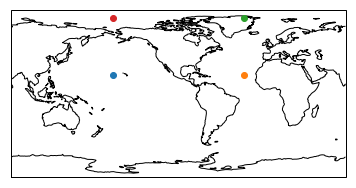

In [45]:
#looking at the area which we are going to analyse

proj = ccrs.PlateCarree(central_longitude = -100.5)
ax = plt.axes(projection = proj)
ax.coastlines()
for i, j in zip(lon,lat):
    ax.plot(i,j,marker = 'o', transform = ccrs.PlateCarree())
    
ax.set_global()

## Reducing Dimensions

In the following, we will reduce our datasize which is strongly spacially corrolated to just a few EOFs. 
The number of EOFs can be chosen based on how much variance of the data we want to explain with our EOFs. 

In [46]:
#PCA

In [47]:
def get_number_eof(X: np.ndarray, var_to_explain: float, plot=False) -> int:
    assert var_to_explain > 0
    assert var_to_explain < 1
    pca = PCA().fit(X)
    var_explained = pca.explained_variance_ratio_
    cum_var = var_explained.cumsum()
    n_eof = np.where(cum_var > var_to_explain)[0].min() + 1
    
    if plot:
        n_padding = 4
        plt.figure(figsize=(12, 7))
        plt.plot(np.arange(1, n_eof + 1 + n_padding), cum_var[0:(n_padding + n_eof)])
        plt.scatter(np.arange(1, n_eof + 1 + n_padding), cum_var[0:(n_padding + n_eof)])
        plt.xlabel('Number of EOFs')
        plt.ylabel('Cumulative Proportion of Variance Explained')
        plt.grid()
        plt.title('{} EOF Retained'.format(n_eof))
        plt.show()
    return n_eof

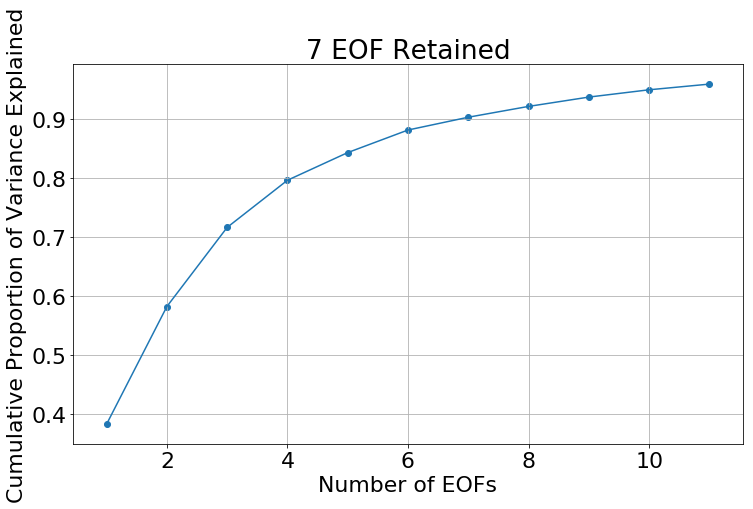

In [48]:
n_eof = get_number_eof(X=reanalysis['ratio'].values, var_to_explain=0.9, plot=True) #here, we chose to represent 90% of the variance.

Now we project the data onto the leading EOFs to get the principal component time series.
We will retain the PCA model for use later.
The `reanalysis_pc` variable is now indexed [`time`, `EOF`].

In [49]:
pca_model = PCA(n_components=n_eof).fit(reanalysis['ratio'].values)
reanalysis_pc = pca_model.transform(reanalysis['ratio'].values)

## Reanalysis Weather Typing

Now we perform the clustering.
We will manually specify the number of clusters we want to create and the number of simulations we want to run.

In [50]:
ncluster = 4 # use 4 WTs
n_sim = 25

Now we can use this to run the classifiability index on our centroids

In [51]:
def _vector_ci(P: np.ndarray, Q: np.ndarray) -> float:
    k = P.shape[0]
    Aij = np.ones([k, k])
    for i in range(k):
        for j in range(k):
            Aij[i, j] = np.corrcoef(P[i, :], Q[j, :])[0, 1]
    Aprime = Aij.max(axis=0)
    ci = Aprime.min()
    return ci

In [52]:
def get_classifiability_index(centroids: np.ndarray) -> Tuple[float, int]:
    nsim = centroids.shape[0]
    c_pq = np.ones([nsim, nsim])
    for i in range(0, nsim):
        for j in range(0, nsim):
            if i == j:
                c_pq[i, j] = np.nan
            else:
                c_pq[i, j] = _vector_ci(P=centroids[i, :, :], Q=centroids[j, :, :])
    classifiability = np.nanmean(c_pq)
    best_part = np.where(c_pq == np.nanmax(c_pq))[0][0]
    return classifiability, best_part

In [53]:
def loop_kmeans(X: np.ndarray, n_cluster: int, n_sim: int) -> Tuple[np.ndarray, np.ndarray]:
    centroids = np.zeros(shape=(n_sim, n_cluster, X.shape[1]))
    w_types = np.zeros(shape=(n_sim, X.shape[0]))
    for i in np.arange(n_sim):
        km = KMeans(n_clusters=n_cluster).fit(X)
        centroids[i, :, :] = km.cluster_centers_
        w_types[i, :] = km.labels_
    return centroids, w_types

In [54]:
centroids, wtypes = loop_kmeans(X=reanalysis_pc, n_cluster=ncluster, n_sim=n_sim)
class_idx, best_part = get_classifiability_index(centroids)
print('The classifiability index is {}'.format(class_idx))

The classifiability index is 0.8974267707739559


Now that we have identified a suitable partition, we can use it to keep only the corresponding centroid and set of weather type labels.
To take advantage of the scikit-learn syntax, we then use these centroids to define a `KMeans` object.

In [55]:
best_fit = KMeans(n_clusters=ncluster, init=centroids[best_part, :, :], n_init=1, max_iter=1).fit(reanalysis_pc)

## Model Weather Types

Now, for each ensemble member, calculate the weather types by projecting the model geopotential height anomaly fields onto the reanalysis regimes and assigning each day of the forecast to the closest centroid in terms of Euclidean distance. The model anomaly fields are first calculated by first taking 5-day running averages and then subtracting the hindcast climatology on a daily basis. The anomalies are then projected into the reanalysis EOFs, and the distances then calculated in EOF space.

In [56]:
# start with reanalysis
reanalysis_composite = reanalysis.copy()
model_clust = best_fit.fit_predict(reanalysis_pc) # get centroids
weather_types = xr.DataArray(
    model_clust, 
    coords = {'time': reanalysis_composite['time']},
    dims='time'
)
reanalysis_composite['WT'] = weather_types
reanalysis_composite = reanalysis_composite.groupby('WT').mean(dim='time').unstack('grid')['ratio']
reanalysis_composite['M'] = 0

In [57]:
wt_anomalies = [] # initialize empty list
wt_anomalies.append(reanalysis_composite)
# loop through each model member
for m in model['M'].values:
    member_data = model['gh'].sel(M=m) # get subset of data
    member_pc_ts = pca_model.transform(member_data.values) # project leading EOFs onto reanalysis EOFs
    member_clust = best_fit.predict(member_pc_ts) # assign to nearest cluster (computed on reanalysis)
    member_clust = weather_types = xr.DataArray(
        model_clust, 
        coords = {'time': model['time']},
        dims='time'
    )
    member_data = member_data.unstack('grid') #
    member_data['WT'] = member_clust
    member_data = member_data.groupby('WT').mean(dim='time')
    wt_anomalies.append(member_data)
wt_anomalies = xr.concat(wt_anomalies, dim='M') # join together
wt_anomalies['WT'] = wt_anomalies['WT'] + 1 # start from 1

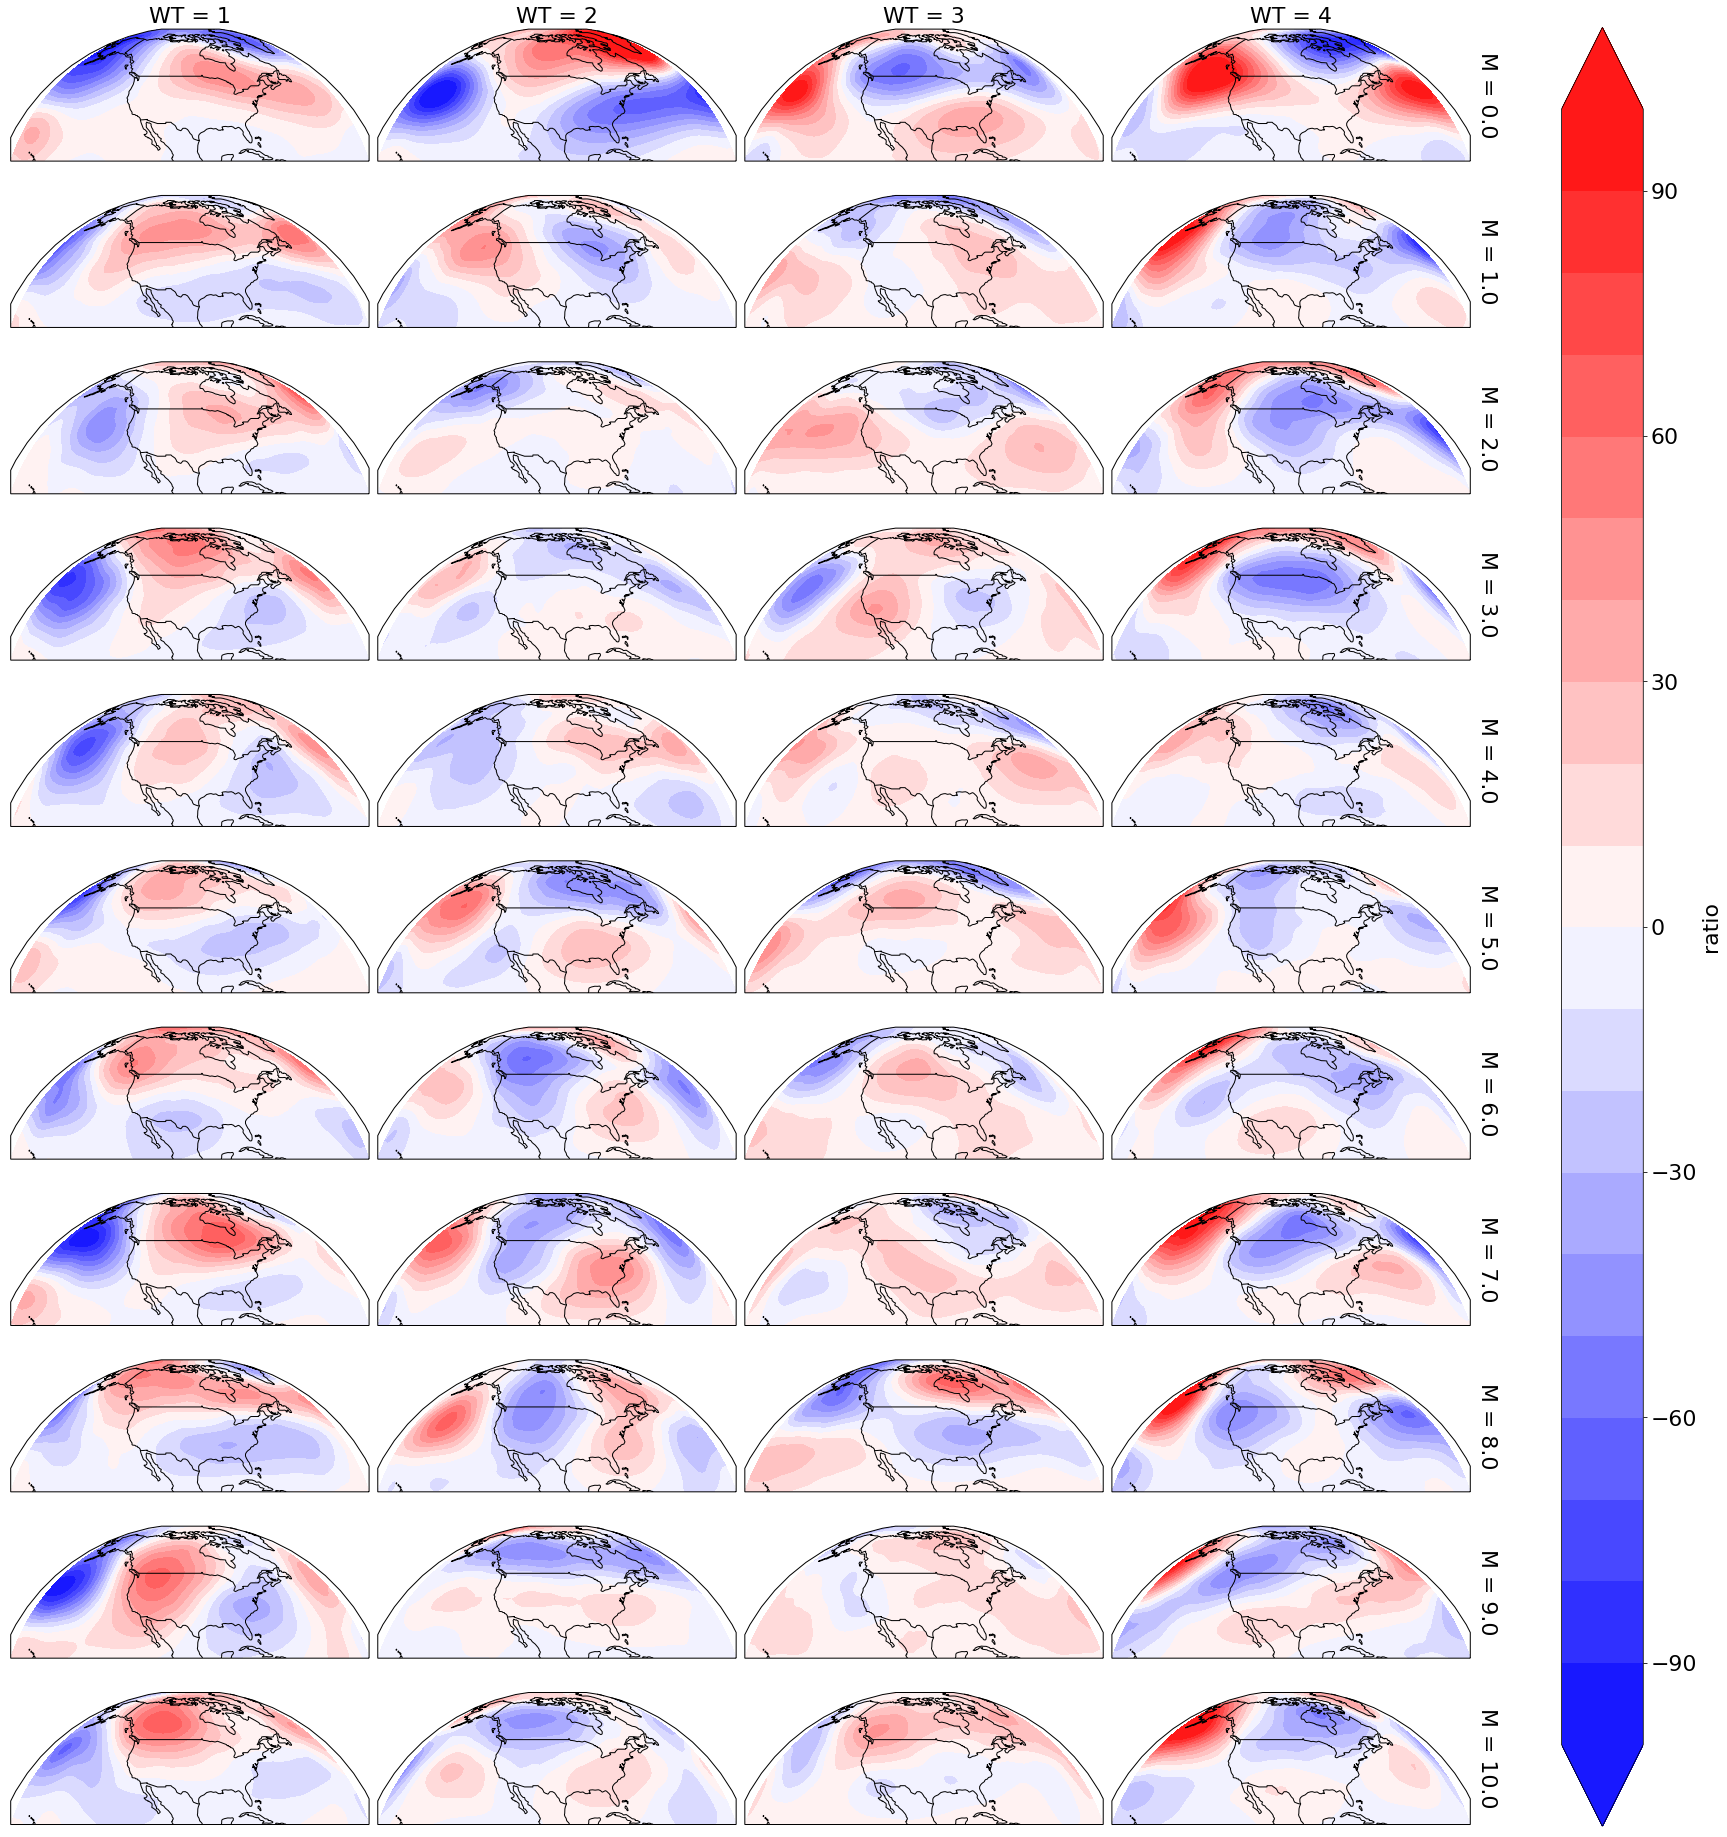

In [60]:
#plt.rcParams.update({'font.size': 22})
central_lat = 90
central_lon = 0
p = wt_anomalies.plot.contourf(
    x='X', y='Y', col='WT', row='M',
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.Orthographic(central_longitude=-100, central_latitude=0)},
    figsize=(26, 26),
    levels = np.linspace(-100, 100, 21),
    cmap=plt.cm.bwr,
    #extend='both'
)

xmin,xmax = wt_anomalies['X'].min(), wt_anomalies['X'].max()
ymin,ymax = wt_anomalies['Y'].min(), wt_anomalies['Y'].max()
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    ax.set_extent([xmin, xmax, ymin, ymax])

plt.show()

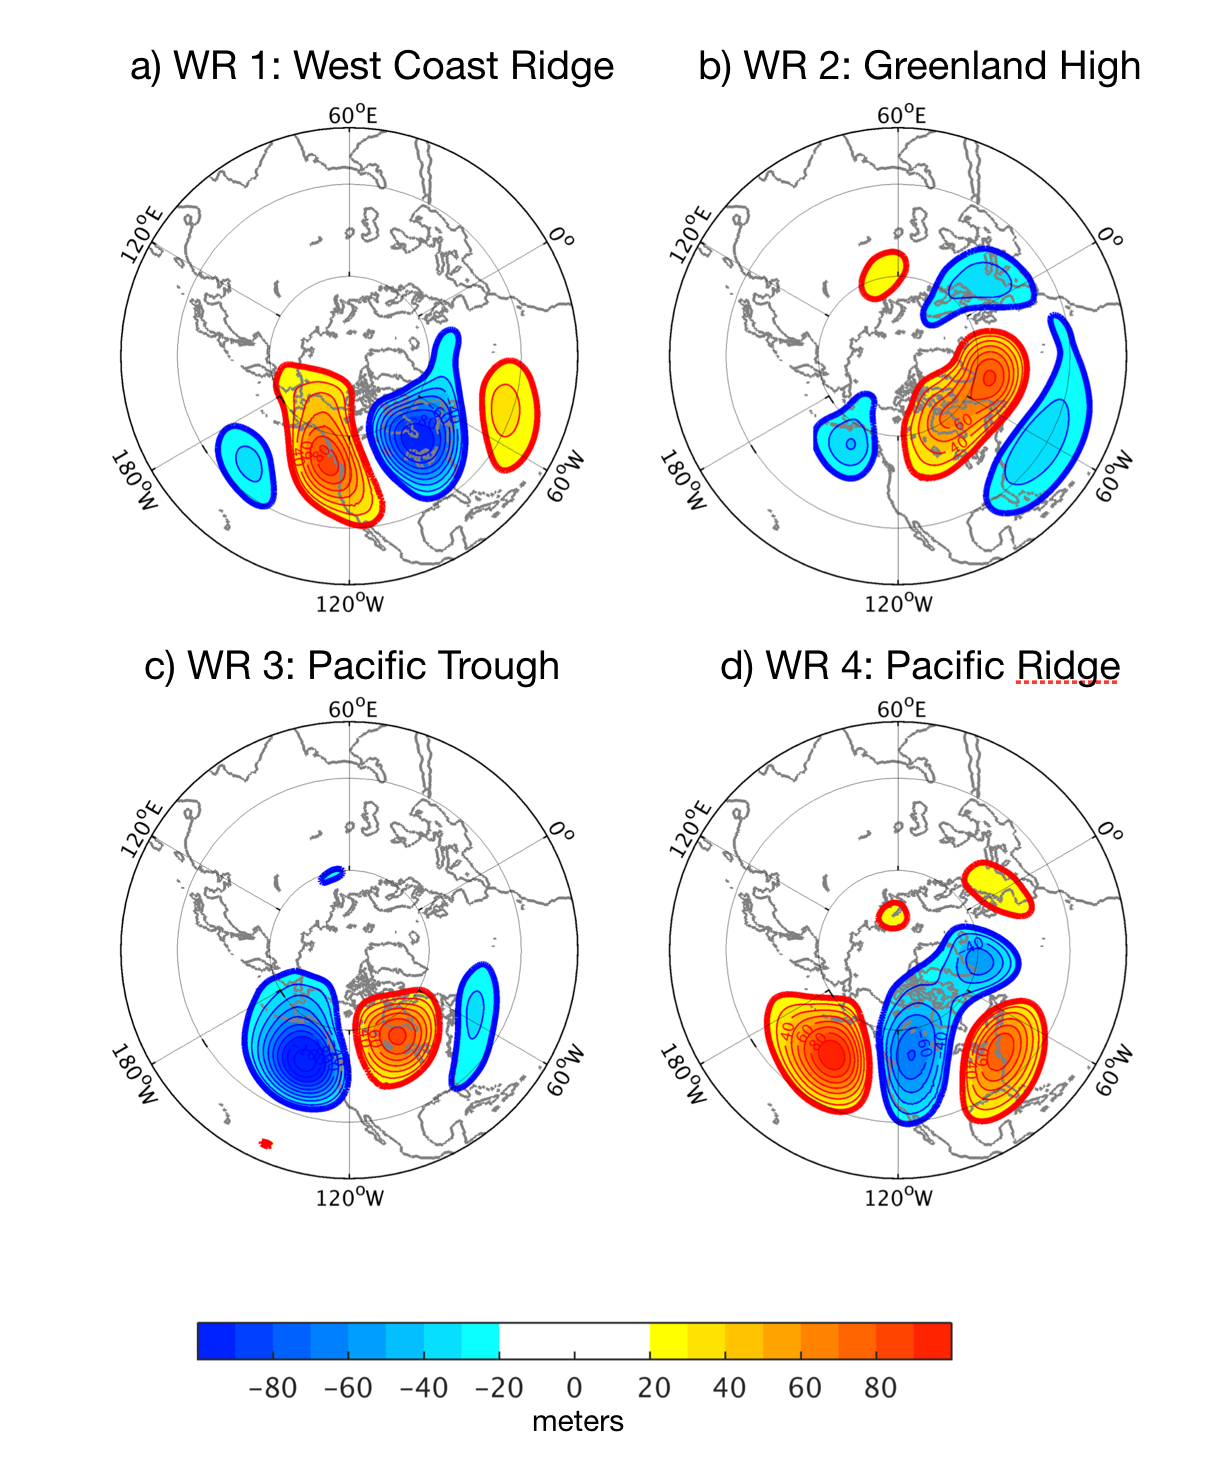

In [61]:
from IPython.display import Image
Image(filename="WRs_MERRA_LP.png",width=600,height=600)

Vigaud, Nicolas, Andrew W. Robertson, and Michael K. Tippett. "Predictability of recurrent weather regimes over North America during winter from submonthly reforecasts." Monthly Weather Review 146.8 (2018): 2559-2577.

## Results
We can see that WR 1 in the paper corresponds to WT = 3, WR 2 corresponds to WT = 4, WR 3 corresponds more or less to WT = 1 and WR 